**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from types import SimpleNamespace
from copy import deepcopy
import time

from scipy import optimize
from scipy import linalg

import sympy as sm

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [26]:
defaults = {
    'alpha': 0.5,
    'kappa': 1.0,
    'nu': 1/(2 * 16**2),
    'w': 1.0,
    'tau': 0.30
}

In [27]:
#Symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
tau = sm.symbols('tau')
G = sm.symbols('G') 
C = sm.symbols('C')
L = sm.symbols('L')
w_tilde = sm.symbols('wtilde')

In [28]:
# Objective function - Utility
utility = sm.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2
print('Utility:')
display(utility)

# Budget Constraint
budget_constraint = kappa + w_tilde * L
print('Budget constraint:')
display(budget_constraint)

# Substituting the budget constraint into the utility function
utility_wrt_L = utility.subs(C, budget_constraint)

# Differentiating with respect to L
foc = sm.diff(utility_wrt_L, L)
solutions = sm.solve(foc, L)
print('Solutions:')
for sol in solutions: display(sol)

Utility:


-L**2*nu/2 + log(C**alpha*G**(1 - alpha))

Budget constraint:


L*wtilde + kappa

Solutions:


(-kappa*nu - sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

There are two possible solutions to the first order condition given by the positive and the negative root. 

To verify the optimal value, we have to run the following simulations :

In [29]:
# Defining the parametric values for choosing the valid solution
param_values_1 = {alpha: 0.5, G: 1, nu: 1/(2 * 16**2), w_tilde: 0.70, kappa: 1}

# Evaluate the solutions and pick the non-negative one
L_star_1 = [sol for sol in solutions if sol.evalf(subs=param_values_1)>=0]

display(L_star_1[0])

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

In [30]:
# Defining the parametric values for choosing the valid solution
param_values_2 = {alpha: 0.5, G: 2, nu: 1/(2 * 16**2), w_tilde: 0.70, kappa: 1}

# Evaluate the solutions and pick the non-negative one
L_star_2 = [sol for sol in solutions if sol.evalf(subs=param_values_2)>=0]

display(L_star_2[0])

(-kappa*nu + sqrt(nu*(4*alpha*wtilde**2 + kappa**2*nu)))/(2*nu*wtilde)

Calculating the first order derivative with both values of G, we get the same solution, the positive root, which is coherent with the proposed answer. Hence, proved.

In [31]:
L_star = L_star_1[0]

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [33]:
L_star_wrt_w = L_star.subs(w_tilde, (1 - tau)*w)

_L_star_fn = sm.lambdify((w, tau, kappa, nu, alpha), L_star_wrt_w) 
L_star_fn = lambda w, tau: _L_star_fn(w, tau, defaults['kappa'], defaults['nu'], defaults['alpha'])

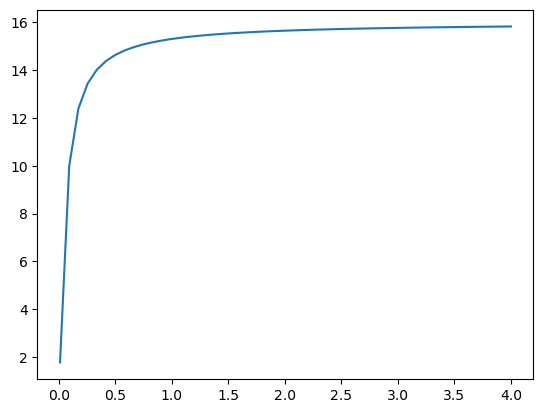

In [36]:
ws = np.linspace(0.01,4,50)
Ls = L_star_fn(ws, defaults['tau'])
plt.plot(ws, Ls)


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [38]:
govt_cons = tau*w*L
_govt_cons_fn = sm.lambdify((tau, L, w), govt_cons)
govt_cons_fn = lambda tau, L: _govt_cons_fn(tau, L, defaults['w'])

In [44]:
utility_wrt_tau = utility_wrt_L.subs(w_tilde, (1 - tau)*w)
_utility_fn = sm.lambdify((tau, L, G, w, alpha, nu, kappa), utility_wrt_tau)
utility_fn = lambda tau, L, G: _utility_fn(tau, L, G, defaults['w'], defaults['alpha'], defaults['nu'], defaults['kappa'])

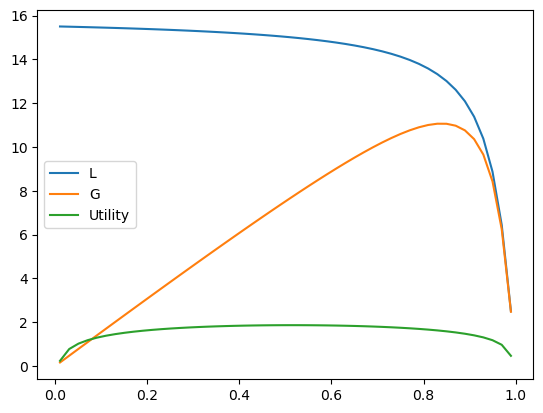

In [50]:
taus = np.linspace(0.01, 0.99, 50)
L_stars = L_star_fn(defaults['w'], taus)
govt_conses = govt_cons_fn(taus, L_stars)
utils = utility_fn(taus, L_stars, govt_conses)

plt.plot(taus, L_stars, label = 'L')
plt.plot(taus, govt_conses, label = 'G')
plt.plot(taus, utils, label = 'Utility')
plt.legend()

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [47]:
def obj(tau):
    L_star = L_star_fn(defaults['w'], tau)
    govt_cons = govt_cons_fn(tau, L_star)
    util = utility_fn(tau, L_star, govt_cons)
    return -util

res = optimize.minimize_scalar(obj, bounds=(0.01, 0.99), method='bounded')
print(res.x, -res.fun)

0.5145311215190458 1.8591992509323028


A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [62]:
epsilon = sm.symbols('epsilon')
sigma = sm.symbols('sigma')
rho = sm.symbols('rho')

set_1 = {
    'sigma': 1.001,
    'rho': 1.001,
    'epsilon': 1.0,
}

set_2 = {
    'sigma': 1.5,
    'rho': 1.5,
    'epsilon': 1.0,
}

In [63]:
# Objective function - Utility
utility =  - nu * (L**(1 + epsilon) / (1 + epsilon)) + ((alpha*C**((sigma - 1)/sigma) + (1 - alpha)*G**((sigma)/(sigma - 1)))**(1 - rho) - 1)/ (1 - rho)
print('Utility:')
display(utility)


Utility:


-L**(epsilon + 1)*nu/(epsilon + 1) + ((C**((sigma - 1)/sigma)*alpha + G**(sigma/(sigma - 1))*(1 - alpha))**(1 - rho) - 1)/(1 - rho)

In [73]:

# Budget Constraint
budget_constraint = kappa + (1 - tau)*w*L
print('Budget constraint:')
display(budget_constraint)

# Substituting the budget constraint into the utility function
utility_wrt_L_1 = utility.subs(C, budget_constraint)
utility_wrt_L_1

Budget constraint:


L*w*(1 - tau) + kappa

-L**(epsilon + 1)*nu/(epsilon + 1) + ((G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))**(1 - rho) - 1)/(1 - rho)

In [75]:
# Differentiating with respect to L
focn = sm.diff(utility_wrt_L_1, L)
focn

alpha*w*(1 - tau)*(sigma - 1)*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))**(1 - rho)*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma)/(sigma*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*w*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L

In [76]:
sm.solve(focn, L)

NotImplementedError: multiple generators [(-G**(sigma/(sigma - 1))*alpha + G**(sigma/(sigma - 1)) - L*alpha*tau*w/(-L*tau*w + L*w + kappa)**(1/sigma) + L*alpha*w/(-L*tau*w + L*w + kappa)**(1/sigma) + alpha*kappa/(-L*tau*w + L*w + kappa)**(1/sigma))**(-rho), (-L*tau*w + L*w + kappa)**(-1/sigma), L, L**epsilon]
No algorithms are implemented to solve equation alpha*w*(1 - tau)*(sigma - 1)*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))**(1 - rho)*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma)/(sigma*(G**(sigma/(sigma - 1))*(1 - alpha) + alpha*(L*w*(1 - tau) + kappa)**((sigma - 1)/sigma))*(L*w*(1 - tau) + kappa)) - L**(epsilon + 1)*nu/L

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [7]:
# write your code here  

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [8]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [9]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [10]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [11]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [12]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [2]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [52]:
def refined_optimizer(K=1000 , K_underbar=10, tau=1e-8, do_print=False):
    """
    Minimize the griewank function using a refined global optimiser.
    """

    # Set random seed to generate replicable behaviour
    np.random.seed(2023)

    # Gather initial random draws
    x0s = -600 + 1200*np.random.uniform(size=(K,2)) # Set bounds to [-600, 600]

    # Allocate arrays to store optimiser's behaviour
    xk0s = np.empty(x0s.shape)
    x_stars = np.empty(x0s.shape)
    f_stars = np.empty(K)
    x_star = np.nan
    f_star = np.inf

    # Loop through K iterations
    for k in range(K):

        # A. Draw random xk (from array of random draws)
        xk = x0s[k]

        # B. When k < K_underbar, set initial guess to random draw.
        if k < K_underbar :
            xk0 = xk

        # C. D. Calculate chi_k and effective initial guess
        else :
            chi_k = 0.50 * 2 / (1 + np.exp((k - K_underbar)/100))
            xk0 = chi_k*xk + (1 - chi_k)*x_star
        xk0s[k] = xk0

        # E. Run optimiser
        res = optimize.minimize(griewank, xk0, method='BFGS', tol=tau)
        xk_star = res.x 
        fk_star = res.fun

        # F. If this is the best solution so far, save result
        if fk_star < f_star:
            f_star = fk_star
            x_star = xk_star
            if do_print: 
                if k == 0: print(f'{"k":>3}   {"xk":>18}   {"xk0":>18}   {"x_star":>22}   {"f_star":>6}')
                print(f'{k:3}   [{xk[0]:+7.2f}, {xk[1]:+7.2f}]   [{xk0[0]:7.2f}, {xk0[1]:7.2f}]   [{x_star[0]:9.4f}, {x_star[1]:9.4f}]   {f_star:5.3f}')

        # Æ. Additionally store current optimal solution for all k
        f_stars[k] = f_star
        x_stars[k] = x_star

        # G. If f_star < tolerance, break loop and return dictionary
        if f_star < tau :
            break
    return {'x_star': x_star, 'f_star': f_star, 'k': k, 'x0s' : x0s, 'xk0s' : xk0s, 'x_stars' : x_stars, 'fk_stars' : f_stars, 'K' : K, 'K_underbar' : K_underbar}
    

Running the optimisation:

In [53]:
res = refined_optimizer(do_print=True)

  k                   xk                  xk0                   x_star   f_star
  0   [-213.61, +468.51]   [-213.61,  468.51]   [-213.5148,  470.4628]   66.795
  1   [+105.66, -448.08]   [ 105.66, -448.08]   [ 103.6179, -448.2743]   52.975
  2   [-430.39,  -38.53]   [-430.39,  -38.53]   [-430.1813,  -39.9450]   46.687
  4   [ +29.26,  +53.92]   [  29.26,   53.92]   [  31.4002,   53.2613]   0.957
  5   [ -52.35,   +1.66]   [ -52.35,    1.66]   [ -50.2404,   -0.0000]   0.631
 33   [ -19.67,  +18.27]   [ -36.71,    8.09]   [ -37.6803,    8.8769]   0.375
103   [+107.48,  -15.23]   [   3.39,    2.06]   [   3.1400,    4.4384]   0.007
319   [-127.97, -158.30]   [  -2.57,   -2.64]   [  -3.1400,   -4.4384]   0.007
368   [+101.77, +228.79]   [  -0.29,    1.89]   [  -0.0000,   -0.0000]   0.000


Illustrating convergence of effective initial guesses over k:

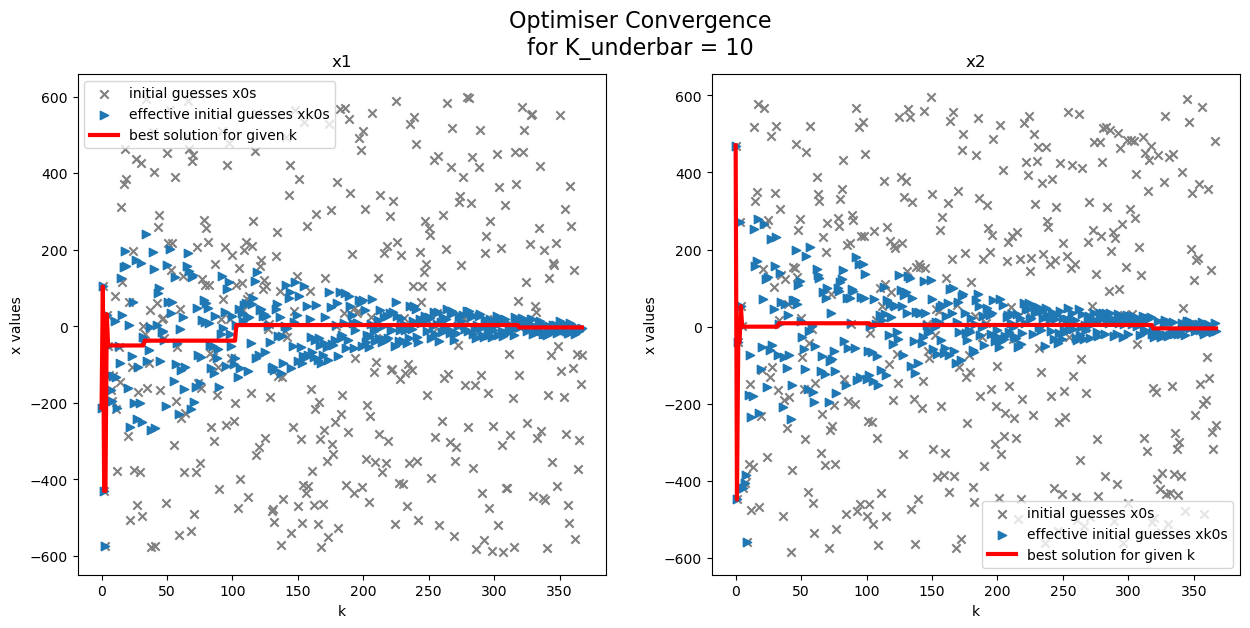

In [5]:
def plot_convergence(res):
    fig, axs = plt.subplots(1,2,figsize=(15,6.5))
    fig.suptitle('Optimiser Convergence\nfor K_underbar = '+str(res['K_underbar']), fontsize=16)
    for i in range(2):
        axs[i].scatter(range(res['k']), res['x0s'][:res['k'],i], label='initial guesses x0s', marker='x', c='grey')
        axs[i].scatter(range(res['k']), res['xk0s'][:res['k'],i], label='effective initial guesses xk0s', marker='>')
        axs[i].plot(range(res['k']), res['x_stars'][:res['k'],i], label='best solution for given k', c='red', lw=3)
        axs[i].set(title='x'+str(i+1), xlabel='k', ylabel='x values')
        axs[i].legend()

plot_convergence(res)


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

Exploring case where K_underbar = 100

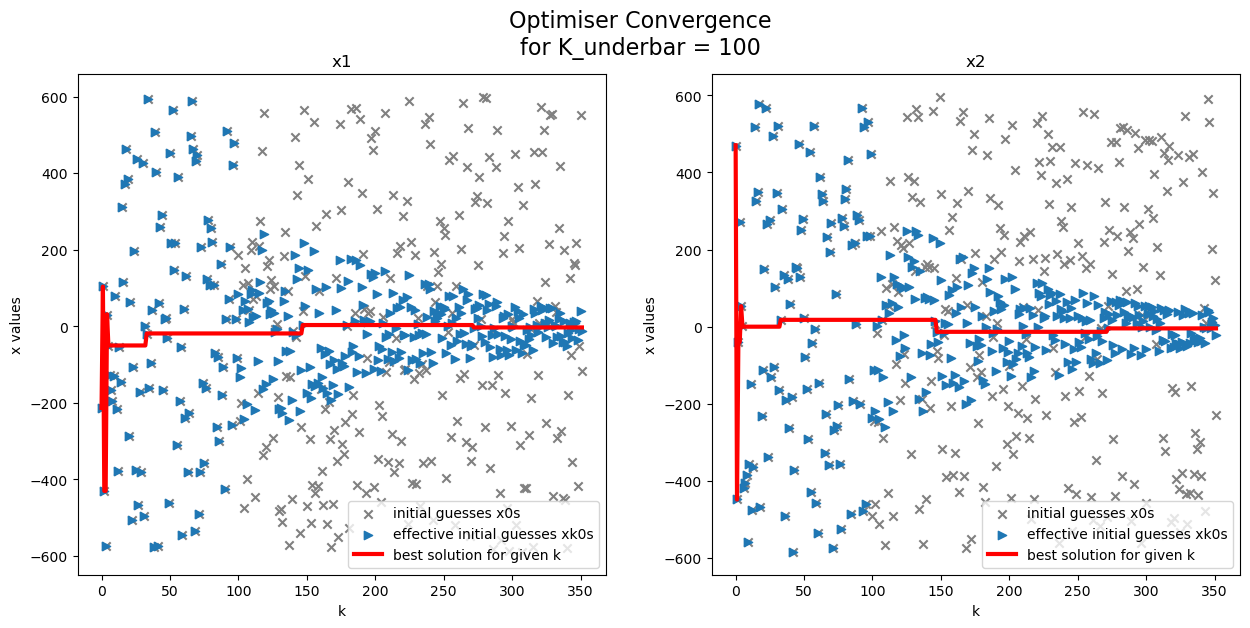

In [6]:
res = refined_optimizer(K_underbar = 100)
plot_convergence(res)

Running the optimization with K_underbar = 100, we see that we need 352 iterations for the functional value to converge to the target 0. In the case of K_underbar = 10, we needed 368. In this direct comparison, it is a better idea to use 100 instead of 10. However, using 100 is not necessarily the optimum since the relationship between the number of final iterations and number of warm up iterations is arbitrary, given the random generator we use. In the next two examples, setting K_underbar to 5 and 54 respectively, we see the number of iterations required is 342 and 272 respectively, therefore justifying our claim.

The K_underbar phase does however represent an exploratative phase which could, in theory and under other random generators, accelerate the rate of convergence, allowing the exploitative phase to hone in on superior solutions.

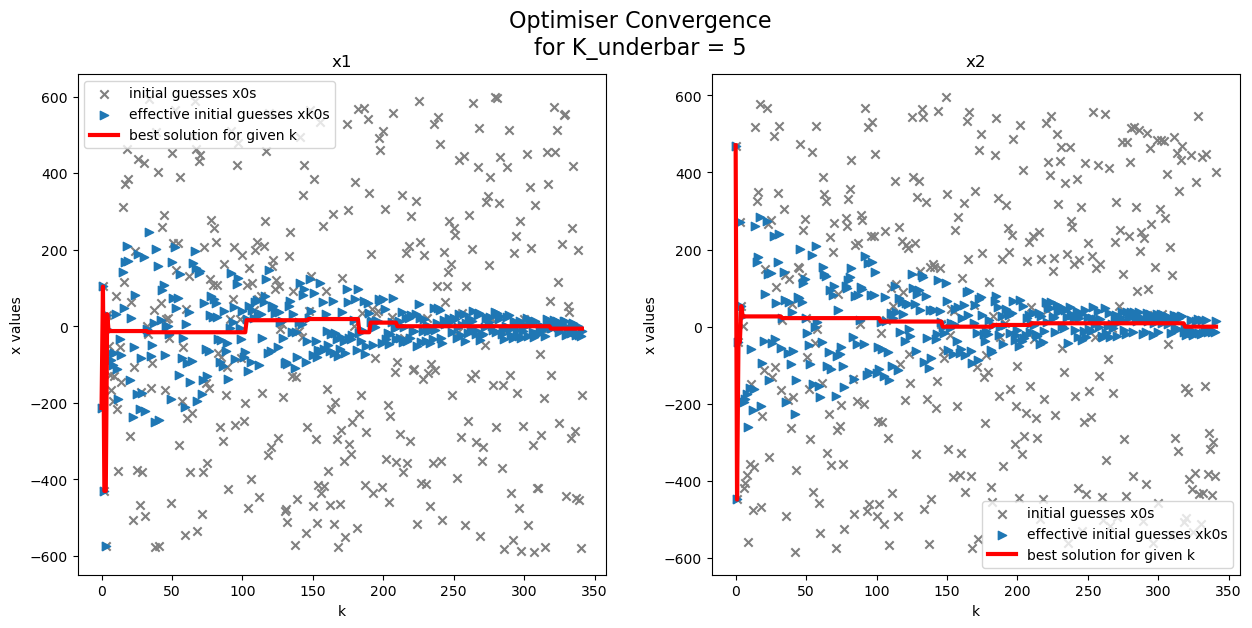

In [7]:
res = refined_optimizer(K_underbar = 5)
plot_convergence(res)

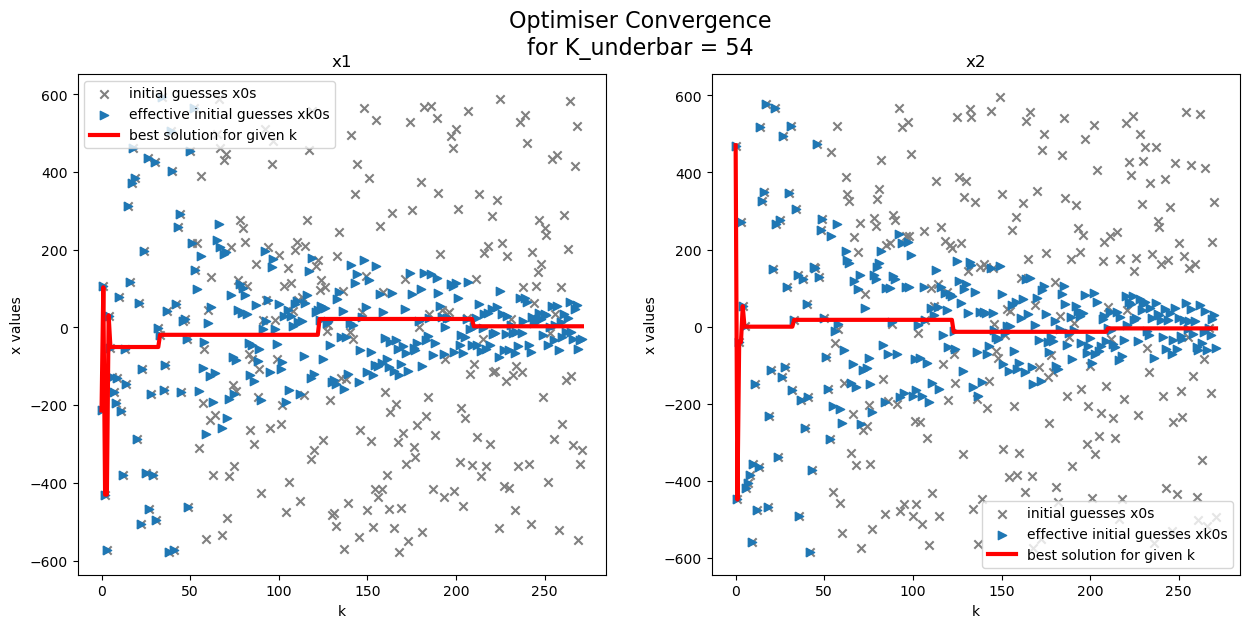

In [8]:
res = refined_optimizer(K_underbar = 54)
plot_convergence(res)